In [1]:
import matplotlib
matplotlib.use('Agg')

import os
import pandas as pd
import numpy as np
import sys
import pickle
from scipy.spatial.distance import cdist
import math
import networkx as nx
import networkx.algorithms.components.connected as nxacc
import networkx.algorithms.dag as nxadag
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import mygene
import re



# Before you begin, navigate to the `GDSC` directory in `../data/` and execute the following command in the terminal 

`wget http://www.cancerrxgene.org/gdsc1000/GDSC1000_WebResources/Data/preprocessed/Cell_line_RMA_proc_basalExp.txt.zip`

Unzip the file once downloaded

# Read in the common features between GDSC and PDTC - this is cruicial for training

In [3]:
selected_exp_gene_list = pd.read_csv("../data/common_exp_features.tsv",sep="\t")["Gene"].tolist()
selected_mut_gene_list = pd.read_csv("../data/common_mut_features.tsv",sep="\t")["Gene"].tolist()

In [4]:
def load_network(network_file_list, valid_gene_list):
    
    gene_neighbor_map = {}
    
    for file_name in network_file_list:
        
        ## print 'Load network', file_name
        
        file_handle = open(file_name)
    
        for line in file_handle:
        
            line = line.rstrip().split()
            gene1, gene2 = line[0], line[1]
        
            if gene1 not in valid_gene_list or gene2 not in valid_gene_list:
                continue
        
            if gene1 not in gene_neighbor_map:
                gene_neighbor_map[gene1] = set()
            if gene2 not in gene_neighbor_map:
                gene_neighbor_map[gene2] = set()
            
            gene_neighbor_map[gene1].add(gene2)
            gene_neighbor_map[gene2].add(gene1)
            
        file_handle.close()
    
    return gene_neighbor_map

In [5]:
def load_name_space():
        
    go_tab_map = {}
    
    file_handle = open(go_name_space_file)
    
    for line in file_handle:
        line = line.rstrip().split()
        go_tab_map[line[0]] = line[1]
        
    file_handle.close()
    
    return go_tab_map
        
def list2index(cell_line_list, cell_line2id):
    
    cell_line_idx_list = []
    
    for cell_line in cell_line_list:
        cell_line_idx_list.append(cell_line2id[cell_line])
        
    return np.asarray(cell_line_idx_list)



In [6]:
def stripNumber(line):
    m = re.match('DATA\.([0-9]+)\.?', line)
    return int(m.group(1))

# Set directories for GDSC and PDTC data

In [14]:
PDTC_data_file = '../data/PDTC/'
PDTC_exp_data_file = PDTC_data_file + 'ExpressionModels.tsv'
PDTC_drug_cell_line_file = PDTC_data_file + 'DrugResponsesAUCModels.tsv'
#download at https://ftp.sanger.ac.uk/pub4/cancerrxgene/releases/release-6.0/v17_fitted_dose_response.xlsx

#cell_line_detail_file = data_file + 'Cell_Lines_Details.csv'
PDTC_mutation_data_file = PDTC_data_file + 'SNVsModels.tsv'
PDTC_drug_target_file ='../data/GDSC/drug_target_list.csv'

inbiomap_file = '../data/networks/InBioMap_Symbol.sif'
pathwaycomm_file = '../data/networks/PathwayCommons_Symbol.sif'

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_row', 10)

In [8]:
data_file = '../data/GDSC/'
new_network_file = '../data/'

exp_data_file = data_file + 'Cell_line_RMA_proc_basalExp.txt'

drug_cell_line_file = data_file + 'v17_fitted_dose_response.csv'
#download at https://ftp.sanger.ac.uk/pub4/cancerrxgene/releases/release-6.0/v17_fitted_dose_response.xlsx

cell_line_detail_file = data_file + 'Cell_Lines_Details.csv'
mutation_data_file = data_file + 'WES_variants.csv'
drug_target_file ='../data/GDSC/drug_target_list.csv'

feature_folder = 'feature/'

inbiomap_file = 'InBioMap_Symbol.sif'
pathwaycomm_file = 'PathwayCommons_Symbol.sif'

In [9]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_row', 10)

# Read in the GDSC and PDTC expression files, and join them into one big dataframe

In [10]:
exp_df = pd.read_csv(exp_data_file, sep='\t', index_col=0)
exp_df = exp_df.T[1:]
exp_df = exp_df.rename(columns={np.nan: 'NO_GENE_NAME'})
exp_df = exp_df.drop('NO_GENE_NAME',axis=1)
exp_df = exp_df[selected_exp_gene_list]
exp_df.index = exp_df.index.map(stripNumber)
exp_df = exp_df.groupby(level=0).first()
PDTC_exp_df = pd.read_csv(PDTC_exp_data_file, sep='\t', index_col=0).fillna(0)
PDTC_exp_df = PDTC_exp_df.T[1:]
PDTC_exp_df = PDTC_exp_df[selected_exp_gene_list]

PDTC_exp_gene_list = list(PDTC_exp_df.columns)
PDTC_exp_cell_line_list = list(PDTC_exp_df.index.unique())
exp_df = pd.concat([exp_df,PDTC_exp_df])
exp_gene_list = list(exp_df.columns)
exp_cell_line_list = list(exp_df.index.unique())

# Read in the GDSC and PDTC expression files, and join them into one big dataframe

In [11]:
maf = pd.read_csv(mutation_data_file, sep=',', index_col=0).fillna(0)
mutation_df = maf.groupby(['COSMIC_ID', 'Gene']).size().unstack().fillna(0)
mutation_df = mutation_df[selected_mut_gene_list]
PDTC_maf = pd.read_csv(PDTC_mutation_data_file, sep='\t', index_col=0).fillna(0)
PDTC_mutation_df= PDTC_maf.replace(to_replace="NO",value=0.0)
PDTC_mutation_df= PDTC_mutation_df.replace(to_replace="chr*",value=1.0,regex=True)
# print len(mutation_cell_line_list), len(mutation_gene_list)
PDTC_mutation_df = PDTC_mutation_df.transpose()
PDTC_mutation_df = PDTC_mutation_df[selected_mut_gene_list]
PDTC_mutation_gene_list = list(PDTC_mutation_df.columns)
PDTC_mutation_cell_line_list = list(PDTC_mutation_df.index.unique())
mutation_df = pd.concat([mutation_df,PDTC_mutation_df])
mutation_gene_list = list(mutation_df.columns)
mutation_cell_line_list = list(mutation_df.index.unique())

# Create a dictionary for each drug, specifying their gene targets

In [12]:
file_handle = open(drug_target_file)

drug_target_map = {}
drug_target_list = []
for line in file_handle:
    
    new_line = line.rstrip().split(",")
    drug = new_line[0]
    target_list=new_line[1].split(',')
    if drug != "Drug":
        target_list_str = ""
        for i in range(0,len(target_list)):
            if i == len(target_list) - 1:
                target_list_str += target_list[i].replace('"','')
            else:
                target_list_str += target_list[i].replace('"','') + ","
        drug = drug.strip()

        drug_target_map[drug] = []
        if ',' not in target_list_str:
            drug_target_map[drug].append(target_list_str.strip())
            drug_target_list.append(target_list_str.strip())
        else:
            target_list = target_list_str.split(',')
            for target in target_list:
                drug_target_map[drug].append(target.strip())
                drug_target_list.append(target.strip())

# Load valid gene neighbour maps for datasets and make identifiers commmon

In [17]:
drugs_legend = pd.read_csv('../data/GDSC/Screened_Compounds.csv', sep=',', index_col=0)

drug2id_mapping = {}

for index in list(drugs_legend.index) :
    drug_name = drugs_legend.loc[index,'Drug Name']
    drug2id_mapping[ drug_name ] = index

valid_gene_list = list(set(drug_target_list) | set(exp_gene_list) | set(mutation_gene_list))

network_list = [inbiomap_file,pathwaycomm_file]
gene_neighbor_map =  load_network(network_list, valid_gene_list)

In [18]:
gene_name_df = pd.read_table('../data/HUGO_protein-coding_gene.tsv',index_col=25, sep='\t')

gene_name_map = {}

for uniprot_gene in gene_name_df.index:
    ## print uniprot_gene
    if isinstance(uniprot_gene, type('aaa')) == False:
        continue
    
    if isinstance(gene_name_df.loc[uniprot_gene, 'symbol'], type('aaa')) == False:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol'][0]
    else:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol']

/var/folders/g5/1dkz6ck51cx3rdj98dn_3jkh0000gp/T/ipykernel_32101/2634738580.py:1: DtypeWarning: Columns (31,38) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_name_df = pd.read_table('../data/HUGO_protein-coding_gene.tsv',index_col=25, sep='\t')


In [19]:
corum_df = pd.read_table(new_network_file + 'allComplexes.txt', index_col=0)

uniprot_gene_set = set()

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
        
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    for gene in complex_list:
        uniprot_gene_set.add(gene)

In [20]:
query_gene_set = []

for gene in uniprot_gene_set:
    if gene not in gene_name_map:
        query_gene_set.append(gene)
    
# print 'Need to query', len(query_gene_set)

query_gene_list = list(query_gene_set)

mg = mygene.MyGeneInfo()
out = mg.querymany(query_gene_list, scopes='uniprot', fields='symbol', species='human')

not_found_gene_list = []

for i, gene in enumerate(query_gene_list):
    if 'notfound' in out[i]:
        not_found_gene_list.append(gene)
    else:
        gene_name_map[gene] = out[i]['symbol']

querying 1-43...done.
Finished.
1 input query terms found dup hits:
	[('P01871', 2)]
26 input query terms found no hit:
	['O15320', 'Q95114', 'Q0VAK7', 'Q9P0W5', 'A6QQ77', 'Q9NY11', 'P62158', 'Q16198', 'Q59EJ3', 'P48830',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [21]:
corum_df = pd.read_table(new_network_file + 'allComplexes.txt', index_col=0)

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
    
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    complex_symbol_list = []
    
    for gene in complex_list:
        if gene in gene_name_map:
            complex_symbol_list.append( gene_name_map[gene] )

    for gene1, gene2 in itertools.combinations(complex_symbol_list,2):
        
        if gene1 not in gene_neighbor_map:
            gene_neighbor_map[gene1] = set()
        if gene2 not in gene_neighbor_map:
            gene_neighbor_map[gene2] = set()
        
        gene_neighbor_map[gene1].add(gene2)
        gene_neighbor_map[gene2].add(gene1)

# Identify significantly expressed genes

In [22]:
gene_exp_neighbor_map = {}
exp_matrix = exp_df.values

P = 1 - cdist(np.transpose(exp_matrix), np.transpose(exp_matrix),'correlation')

for i in range(len(exp_gene_list)):
    
    gene1 = exp_gene_list[i]
    gene_exp_neighbor_map[gene1] = set()
    
    for j in range(len(exp_gene_list)):
        
        gene2 = exp_gene_list[j]
        
        if math.fabs(P[i, j]) > 0.4:
            gene_exp_neighbor_map[gene1].add(gene2)
            
    if gene1 not in gene_exp_neighbor_map[gene1]:
        print (gene1, 'not in itself?', P[i,i])

# Identify drugs expressed in input data, and which to be "selected" for analysis

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

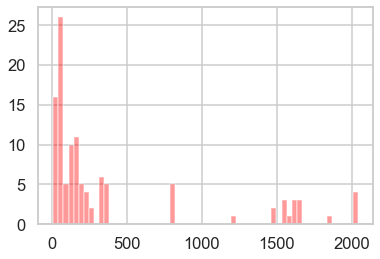

In [24]:
%matplotlib inline
drug_feature_list = []
drug_neighbor_map = {}
selected_drug_list = []

for drug, target_list in drug_target_map.items():
        drug_neighbor_map[drug] = set()

        for gene in target_list:

            if gene not in gene_exp_neighbor_map and gene not in gene_neighbor_map:
                continue

            if gene in gene_exp_neighbor_map:
                drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_exp_neighbor_map[gene]

            if gene in gene_neighbor_map:
                drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_neighbor_map[gene]

        if len(drug_neighbor_map[drug]) != 0:
             selected_drug_list.append(drug)
             drug_feature_list.append( len(drug_neighbor_map[drug]) )
sns.set_style("whitegrid")
sns.set_context("talk")
sns.distplot(drug_feature_list,color='r',bins=60,kde=False,norm_hist=False)

# Load GDSC and PDTC drug information

In [25]:
drugs = pd.read_csv(drug_cell_line_file,index_col=2)
drugs = drugs.drop(["DATASET_VERSION","IC50_RESULTS_ID","MAX_CONC_MICROMOLAR","RMSE"],axis=1)
drugs_cell_line_list = list(drugs.index.unique())
# print len(drugs_cell_line_list)
drug_list = drugs["DRUG_ID"]
new_drug_id = []

PDTC_drugs = pd.read_csv(PDTC_drug_cell_line_file,sep='\t',index_col=0)
PDTC_drugs_cell_line_list = list(PDTC_drugs.index.unique())
# print len(drugs_cell_line_list)
drug_list = PDTC_drugs["Drug"].tolist()
new_drug_id = []
for i in drug_list:
    if i in drug2id_mapping.keys():
        new_drug_id.append(drug2id_mapping[i])
    else:
        new_drug_id.append(0)
PDTC_drugs["DRUG_ID"] = new_drug_id
PDTC_drugs["LN_IC50"] = np.log(PDTC_drugs["iC50"])
PDTC_drugs = PDTC_drugs.drop(["Drug","iC50","D1_CONC","D5_CONC","perc.iC50"],axis=1)

drugs = pd.concat([drugs,PDTC_drugs])

drugs_cell_line_list = list(drugs.index.unique())



In [26]:
cell_line_list = list(set(drugs_cell_line_list)&set(exp_cell_line_list)&set(mutation_cell_line_list) )

cell_line_legend = pd.read_csv(cell_line_detail_file, index_col=1)
PDTC_cell_line = pd.DataFrame({'Line': ["BRCA"]*len(PDTC_exp_cell_line_list), 'Site':["PDTC"]*len(PDTC_exp_cell_line_list),"Histology":["breast"]*len(PDTC_exp_cell_line_list)},index=PDTC_exp_cell_line_list)
cell_line_legend = pd.concat([cell_line_legend,PDTC_cell_line])

# Identify present tissues in dataset (note: PDTC breast tissue has been identified as "PDTC")

In [28]:
tissue_map = {}

for cell_line in cell_line_list:
    
    tissue = cell_line_legend.loc[cell_line,'Site']
    
    if tissue not in tissue_map:
        tissue_map[tissue] = []
        
    tissue_map[tissue].append(cell_line)

large_tissue_number = 0
for tissue, cell_line in tissue_map.items():
    
    if len(cell_line) >= 15:
        large_tissue_number += 1
    
    print (tissue, len(cell_line))

print('How many tissues', len(tissue_map))
print('Large tissues', large_tissue_number)

haematopoietic_and_lymphoid_tissue 163
central_nervous_system 56
stomach 28
bone 40
pancreas 32
large_intestine 48
lung 169
soft_tissue 22
urinary_tract 19
autonomic_ganglia 29
oesophagus 35
upper_aerodigestive_tract 42
ovary 41
breast 50
PDTC 19
cervix 13
endometrium 11
thyroid 15
skin 55
liver 16
adrenal_gland 1
vulva 3
prostate 7
biliary_tract 5
kidney 31
salivary_gland 2
pleura 21
NS 3
testis 2
placenta 2
small_intestine 1
How many tissues 31
Large tissues 20


In [29]:
new_exp_gene_list = []
for i in exp_gene_list:
    if i in valid_gene_list:
        new_exp_gene_list.append(i)

exp_stdev = np.std(exp_df.values, axis=0)
exp_perc = np.percentile(exp_stdev,10)
filtered_exp_gene_list = np.asarray(exp_gene_list)[exp_stdev > exp_perc]

mut_sum = np.sum(mutation_df.values,axis=0)
filtered_mut_gene_list = np.asarray(mutation_gene_list)[mut_sum > 5]

new_exp_df = exp_df.loc[ :, list(filtered_exp_gene_list) ]
new_mutation_df = mutation_df.loc[ :, list(filtered_mut_gene_list) ]

In [30]:
new_data_file = ''

exp_stdev = np.std(exp_df.values, axis=0)
exp_perc = np.percentile(exp_stdev,10)
filtered_exp_gene_list = np.asarray(exp_gene_list)[exp_stdev > exp_perc]

mut_sum = np.sum(mutation_df.values,axis=0)
filtered_mut_gene_list = np.asarray(mutation_gene_list)[mut_sum > 5]

new_exp_df = exp_df.loc[ :, list(filtered_exp_gene_list) ]
new_mutation_df = mutation_df.loc[ :, list(filtered_mut_gene_list) ]

# Generate tissue feature and labels for each drug (input for pipeline)

In [31]:
rename_selected_drug_list = []

for drug in selected_drug_list:
    print(drug)
    
    if drug not in drug2id_mapping:
        print('drug name wrong', drug)
    else:
        cell_line_drug_matrix = drugs.loc[drugs['DRUG_ID'] == drug2id_mapping[drug]]
        
        feature_exp_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_exp_gene_list) )
        feature_mut_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_mut_gene_list) )
        print(len(feature_exp_gene_list) + len(feature_mut_gene_list))
        if len(feature_exp_gene_list) + len(feature_mut_gene_list) == 0:
            continue
        feature_description = []

        drug_tissue_map = {}

        drug = drug.replace(' ','_')

        rename_selected_drug_list.append(drug)

        # print drug
        if drug == 'Nutlin-3a_(-)':
            drug = 'Nutlin-3a'

        drug_folder = '../data/merged/drug_feature/' + drug + '/'
        if not os.path.exists(drug_folder):
            os.makedirs(drug_folder)

        # print 'Generate features', drug

        for tissue, tissue_cell_line_list in tissue_map.items():
            drug_specific_cell_line = set( cell_line_drug_matrix.index ) & set( tissue_cell_line_list )
            drug_specific_cell_line = list(drug_specific_cell_line)
            drug_tissue_map[tissue] = drug_specific_cell_line

            feature_list = []

            if len(feature_exp_gene_list) != 0:
                feature_list.append( new_exp_df.loc[ drug_specific_cell_line, feature_exp_gene_list ].values )
                for gene in feature_exp_gene_list:
                    feature_description.append(gene+'_expression')

            if len(feature_mut_gene_list) != 0:
                feature_list.append( mutation_df.loc[ drug_specific_cell_line, feature_mut_gene_list ].values )
                for gene in feature_mut_gene_list:
                    feature_description.append(gene+'_mutation')

            feature = np.concatenate(feature_list, axis=1)

            label = cell_line_drug_matrix.loc[ drug_specific_cell_line,'LN_IC50'].values

            #label = new_crispr_df.loc[ tissue_cell_line_list, label_gene ].values

            # print feature.shape, label.shape

            np.save(drug_folder + tissue + '_' + drug + '_feature.npy', feature )
            np.save(drug_folder + tissue + '_' + drug + '_label.npy', label)
            np.save(drug_folder + tissue + '_feature_description.npy', np.asarray(feature_description))

        file_handle = open("../data/merged/" + drug+'_tissue_cell_line_list.pkl',"wb")
        pickle.dump(drug_tissue_map,file_handle)
        file_handle.close()
    
file_handle = open('rename_selected_drug_list', 'w')
for drug in rename_selected_drug_list:
    file_handle.writelines(drug+ '\n')
file_handle.close()

Erlotinib
288
Rapamycin
41
Sunitinib
36
PHA-665752
52
Cyclopamine
36
AZ628
657
Sorafenib
36
VX-680
drug name wrong VX-680
NVP-TAE684
1286
Crizotinib
52
AZD-0530
drug name wrong AZD-0530
S-Trityl-L-cysteine
41
CGP-60474
219
CGP-082996
100
WZ-1-84
1033
BI-2536
116
BMS-536924
51
BMS-509744
41
JW-7-52-1
41
A-443654
1781
GW843682X
116
Parthenolide
115
Lapatinib
119
GSK269962A
15
CP466722
130
Midostaurin
43
CHIR-99021
118
JQ1
1464
AKT inhibitor VIII
1781
Embelin
46
IPA-3
91
GSK-650394
drug name wrong GSK-650394
BAY 61-3606
drug name wrong BAY 61-3606
Obatoclax Mesylate
1345
BMS-754807
51
OSI-906
drug name wrong OSI-906
LFM-A13
287
GSK-1904529A
drug name wrong GSK-1904529A
BMS-345541
51
Ruxolitinib
62
SB-715992
drug name wrong SB-715992
AT-7519
1387
Genentech Cpd 10
101
GSK1070916
126
KIN001-102
drug name wrong KIN001-102
GSK429286A
9
QL-XII-47
287
WZ3105
48
XMD14-99
24
AC220
drug name wrong AC220
CP724714
119
JW-7-24-1
132
NPK76-II-72-1
25
Tubastatin A
61
NSC-207895
22
I-BET 151
drug name wr